In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from primera.utils.pretrain_preprocess import *
import re
from nltk import sent_tokenize
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
import pickle

#### Load data

In [ ]:
ms2=load_dataset("allenai/mslr2022","ms2")
#cochrane=load_dataset("allenai/mslr2022","cochrane")

In [69]:
#cochrane_df=cochrane["train"].to_pandas()
ms2_df=ms2["train"].to_pandas()
#all_datasets=[cochrane_df,ms2_df]

In [70]:
ms2_df.drop(columns=['background','review_id','pmid'],inplace=True)
#cochrane_df.drop(columns=['review_id','pmid'],inplace=True)
#train_df=pd.concat([ms2_df,cochrane_df],axis=0).reset_index(drop=True)
train_df=ms2_df

#### Turn each data instance into a list of list of sentences

In [71]:
def sent_tokenize_text(tit,abst):
    text=[]
    assert len(tit)==len(abst)
    for i in range(len(abst)):
        if tit[i].endswith(".") or tit[i].endswith("!") or tit[i].endswith("?"):
            text.append(tit[i]+" "+abst[i])
        else : text.append(tit[i]+". "+abst[i])
    return [sent_tokenize(s) for s in text]
train_df["all_docs"]=train_df.apply(lambda row: sent_tokenize_text(row['title'],row['abstract']),axis=1)
train_df["target"]=train_df["target"].astype(str)
train_df.drop(columns=['title','abstract'],inplace=True)

In [72]:
train_df.head()

,target,all_docs
0,Conclusions SC therapy is effective for PAH in...,[[Improved Cell Survival and Paracrine Capacit...
1,There was a trend for endothelin receptor anta...,[[A comparison of continuous intravenous epopr...
2,This present meta- analysis suggests that stat...,[[Relationship of TIMI myocardial perfusion gr...
3,"In conclusion , there is a lack of evidence of...",[[Effect of cessation interventions on hookah ...
4,Several PROMs have been identified to evaluate...,[[The Arizona Sexual Experiences Scale: a vali...


#### Define parameters and load tokenizer

In [18]:
MAX_LEN_INPUT=4096
MAX_LEN_OUTPUT=512
MASK_RATIO=0.3
NON_MASK_RATIO=0.5
scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True
    )

In [19]:
tokenizer=AutoTokenizer.from_pretrained("./primera-tokenizer")

#### Truncate data

In [74]:
train_df["truncated_docs"]=train_df["all_docs"].apply(lambda row: truncate(row,MAX_LEN_INPUT,MASK_RATIO,NON_MASK_RATIO))

##### Compare length of the clusters before truncated and after truncated

In [21]:
before=[]
after=[]
for i,row in train_df.iterrows():
    before.append(sum([len(s.split()) for doc in row["all_docs"] for s in doc]))
    after.append(sum([len(s.split()) for doc in row["truncated_docs"] for s in doc]))

Mean:  7193.434451649281
Median:  5161.5
Max:  128955


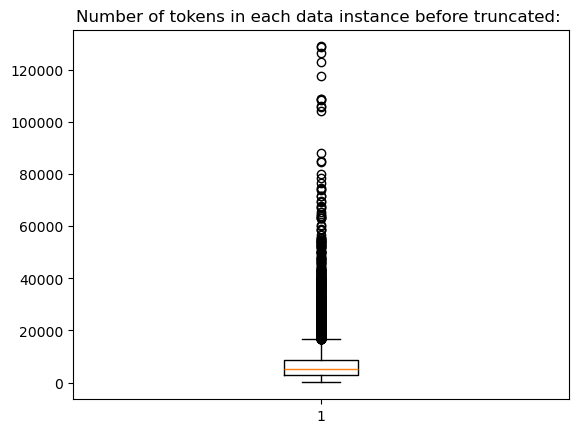

In [22]:
plt.boxplot(before)
plt.title("Number of tokens in each data instance before truncated: ")
print("Mean: ",np.mean(before))
print("Median: ",np.median(before))
print("Max: ",np.max(before))
plt.show()

Mean:  3399.8600930363687
Median:  3800.0
Max:  4543


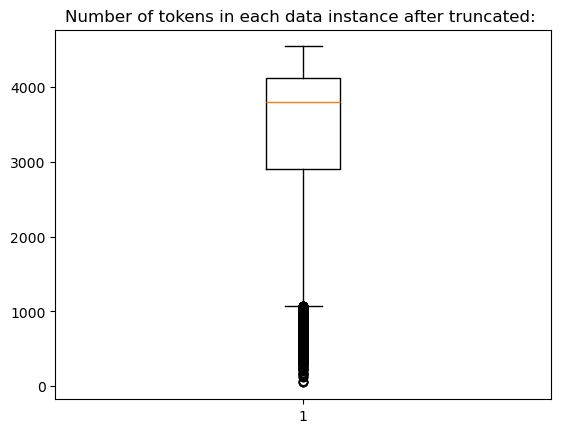

In [23]:
plt.boxplot(after)
plt.title("Number of tokens in each data instance after truncated: ")
print("Mean: ",np.mean(after))
print("Median: ",np.median(after))
print("Max: ",np.max(after))
plt.show()

#### Select salient sentences

In [29]:
all_selected_sents = []
current_len=0

In [ ]:
with open("selected_sents.pkl","rb+") as f:
    all_selected_sents=pickle.load(f)
current_len=len(all_selected_sents)

In [ ]:
with open("selected_sents.pkl","wb+") as f:
    for i, row in train_df.iterrows():
        if i<current_len:
            continue
        entity_pyramid = get_entities(row["all_docs"])
        rouge_score_dict = compute_rouge_scores(row["all_docs"], scorer)
        total_num_sentences = sum(len(doc) for doc in row["truncated_docs"])
        num_sents_to_mask = int(total_num_sentences * MASK_RATIO)
        selected_sents = select_salient_sentences(
            row["truncated_docs"], rouge_score_dict, entity_pyramid, num_sents_to_mask
        )
        all_selected_sents.append(selected_sents)  
        if i%50==0 or i==train_df.shape[0]-1:
            pickle.dump(all_selected_sents,f)
            print(f"Save up to row {i}")
        print(f"Done row {i}")

In [91]:
row=train_df.loc[train_df.shape[0]-1]
entity_pyramid = get_entities(row["all_docs"])
rouge_score_dict = compute_rouge_scores(row["all_docs"], scorer)
total_num_sentences = sum(len(doc) for doc in row["truncated_docs"])
num_sents_to_mask = int(total_num_sentences * MASK_RATIO)
selected_sents = select_salient_sentences(
    row["truncated_docs"], rouge_score_dict, entity_pyramid, num_sents_to_mask
)

In [96]:
train_df["selected_sents"]=all_selected_sents

In [97]:
train_df.drop(columns=["all_docs","target"],inplace=True)

In [98]:
train_df = train_df[train_df["selected_sents"].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [99]:
train_df.index

RangeIndex(start=0, stop=14184, step=1)

In [100]:
train_df.to_csv("pretrained_data.csv", index=False)

In [101]:
pretrained_df=pd.read_csv("pretrained_data.csv")
pretrained_df.head()

,truncated_docs,selected_sents
0,[['Improved Cell Survival and Paracrine Capaci...,"[(4, 0), (3, 4), (4, 3), (3, 1), (3, 7), (4, 6..."
1,[['A comparison of continuous intravenous epop...,"[(0, 2), (0, 5), (1, 0), (1, 6), (0, 8), (1, 3..."
2,[['Relationship of TIMI myocardial perfusion g...,"[(0, 2), (0, 5), (2, 2), (1, 0), (1, 6), (2, 5..."
3,[['Effect of cessation interventions on hookah...,"[(3, 4), (3, 1), (0, 2), (0, 5), (2, 2), (1, 0..."
4,"[[""The Arizona Sexual Experiences Scale: a val...","[(0, 2), (0, 5), (1, 0), (0, 8), (1, 3), (0, 1..."
